## Imports

In [47]:
import os
import cv2 as cv
import math

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as f
import torchmetrics
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import torchvision
from torchvision import transforms, models

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data Import

In [49]:
PATH = '/content/drive/MyDrive/2024-25/Advanced-Programming-and-Machine-Learning-IITM/final_project/EyeDisease_Classification/dataset'

# Created label mappings
label_to_id = {label: i for i, label in enumerate(os.listdir(PATH))}
id_to_label = {value: key for key, value in label_to_id.items()}

# List of filenames and outcomes
filenames = []
outcomes = []
for label in os.listdir(PATH):
    for img in os.listdir(os.path.join(PATH, label)):
        filenames.append(os.path.join(PATH, label, img))
        outcomes.append(label_to_id[label])

# Creating dataframe
df = pd.DataFrame({'filename': filenames, 'outcome': outcomes})
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,filename,outcome
0,/content/drive/MyDrive/2024-25/Advanced-Progra...,3
1,/content/drive/MyDrive/2024-25/Advanced-Progra...,3
2,/content/drive/MyDrive/2024-25/Advanced-Progra...,2
3,/content/drive/MyDrive/2024-25/Advanced-Progra...,3
4,/content/drive/MyDrive/2024-25/Advanced-Progra...,1


## Data Exploration and Analysis

<ipython-input-50-d9012af6693e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='outcome', data=df, palette='viridis')


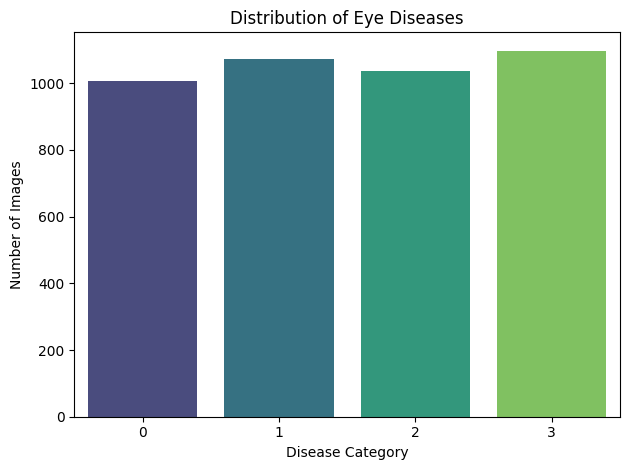

In [50]:
# Graph to explore the distribution of different classes.
sns.countplot(x='outcome', data=df, palette='viridis')

plt.title('Distribution of Eye Diseases')
plt.xlabel('Disease Category')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

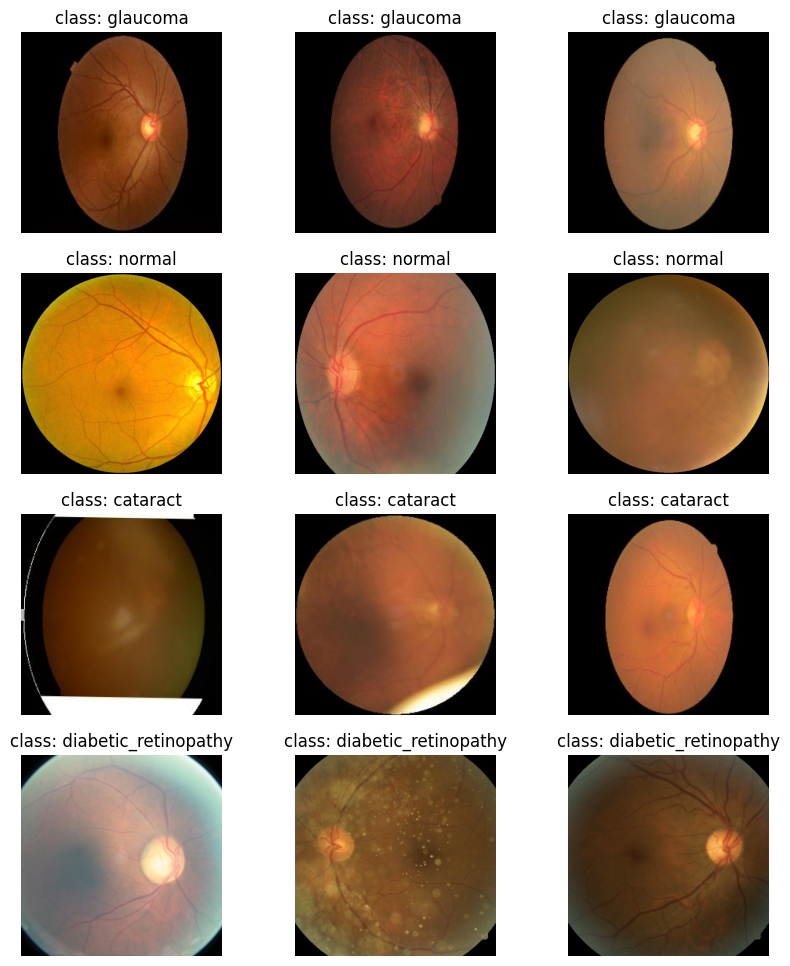

In [51]:
# Sample plotting to see the iamges.
img_count = 0
plt.figure(figsize=(10, 12))
for i in range(4):
  for path in df[df['outcome'] == i].sample(n=3)['filename']:
    plt.subplot(4, 3, img_count + 1)
    img = plt.imread(path)
    img = (img - img.min()) / img.max()
    plt.imshow(img)
    plt.axis('off')
    plt.title('class: ' + id_to_label[i])
    img_count += 1
plt.show()

## Data Preprocessing

In [52]:
# Data Augmentation, Making sure all the images are of same size.
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224))
])

In [53]:
class EyeDataset(Dataset):
  def __init__(self, data, num_classes, transform=None):
    self.data = data
    self.num_samples = len(self.data)
    self.num_classes = num_classes
    self.transform = transform


  def __len__(self):
    return self.num_samples


  def __getitem__(self, index):
    image_path = self.data.iloc[index, 0]
    label = self.data.iloc[index, 1]
    image = plt.imread(image_path)
    image = (image - image.min()) / image.max()
    if self.transform:
        image = self.transform(image)
    return image.to(torch.float32), label

In [54]:
# Data splitting and loading
NUM_CLASSES = 4
BATCH_SIZE = 128

train_df, val_df = train_test_split(df, test_size=0.20, random_state=28)

train_dataset = EyeDataset(train_df, NUM_CLASSES, data_transform)
val_dataset = EyeDataset(val_df, NUM_CLASSES, val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [55]:
# Test data loading
image_batch, label_batch = next(iter(train_loader))
print(image_batch.shape, label_batch.shape)

torch.Size([128, 3, 224, 224]) torch.Size([128])


## Building the model

In [56]:
# I built two models for this task, one based on ResNet and one convolutional network from scratch.
class EyeClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    # Convolutional layers
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    # Max pooling
    self.pool = nn.MaxPool2d(2, 2)
    # Fully connected layers
    self.fc1 = nn.Linear(512 * 7 * 7, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 4)  # Output layer with 4 classes
    self.relu = nn.ReLU()


  def forward(self, x):
    # Convolutional blocks
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = self.relu(self.conv3(x))
    x = self.pool(x)
    x = self.relu(self.conv4(x))
    x = self.pool(x)
    x = self.relu(self.conv5(x))
    x = self.pool(x)

    # Flatten
    x = torch.flatten(x, 1)

    # Fully connected layers
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x


  def configure_optimizer(self):
    return torch.optim.AdamW(self.parameters(), lr=1e-3)

In [57]:
# Model Definition
class EyeClassifierResNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.base_model = torchvision.models.resnet18(pretrained=True)
    # Freeze most layers of ResNet18, So that we can use pre weights.
    for param in list(self.base_model.parameters())[:-15]:
      param.requires_grad = False
    # Custom classification head
    self.head = nn.Sequential(
      nn.Linear(512, 128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128, 4)
    )
    # Replacing ResNet18 original classification layers to train our custom model
    self.base_model.fc = nn.Sequential()
    self.base_model.classifier = nn.Sequential()


  def forward(self, x):
    features = self.base_model(x)
    output = self.head(features)
    return output


  def configure_optimizer(self):
    return torch.optim.AdamW([
        {'params': self.base_model.parameters(), 'lr': 3e-5},
        {'params': self.head.parameters(), 'lr': 8e-4}
    ])

In [58]:
# Training Class
class ModelTrainer:
  def __init__(self, train_data, val_data, device):
    self.train_data = train_data
    self.val_data = val_data
    self.device = device
    self.model = EyeClassifierResNet().to(self.device)
    self.optimizer = self.model.configure_optimizer()
    self.loss_fn = nn.CrossEntropyLoss()
    self.accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(self.device)
    self.training_history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }


  def train_step(self, batch):
    inputs, labels = batch
    inputs, labels = inputs.to(self.device), labels.to(self.device)
    predictions = self.model(inputs)
    loss = self.loss_fn(predictions, labels)
    accuracy = self.accuracy_metric(predictions, labels)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    return loss.item(), accuracy.item()


  def validation_step(self, batch):
    inputs, labels = batch
    inputs, labels = inputs.to(self.device), labels.to(self.device)
    with torch.no_grad():
      predictions = self.model(inputs)
      loss = self.loss_fn(predictions, labels)
      accuracy = self.accuracy_metric(predictions, labels)
    return loss.item(), accuracy.item()


  def run_epoch(self, epoch, data_loader, step_function):
    epoch_loss, epoch_acc = 0, 0
    for batch in tqdm(data_loader, desc=f"Epoch {epoch+1} - {step_function.__name__}"):
      loss, acc = step_function(batch)
      epoch_loss += loss
      epoch_acc += acc
    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)


  def train_model(self, num_epochs):
    for epoch in range(num_epochs):
      train_loss, train_acc = self.run_epoch(epoch, self.train_data, self.train_step)
      val_loss, val_acc = self.run_epoch(epoch, self.val_data, self.validation_step)
      self.training_history['train_loss'].append(train_loss)
      self.training_history['val_loss'].append(val_loss)
      self.training_history['train_acc'].append(train_acc)
      self.training_history['val_acc'].append(val_acc)
      print(
        f"[Epoch: {epoch+1}] Train: [loss: {train_loss:.3f} acc: {train_acc:.3f}] "
        f"Val: [loss: {val_loss:.3f} acc:{val_acc:.3f}]"
      )

## Training the model

In [59]:
# Assuming train_loader and val_loader are defined previously
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainer = ModelTrainer(train_loader, val_loader, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
trainer.train_model(num_epochs=3)
# I trained on different epochs and if the epoch count is going up the model is starting to overfit and reducing the quality of results.
# I found the optimal epoch count is 3 to 5

Epoch 1 - validation_step: 100%|██████████| 7/7 [00:23<00:00,  3.30s/it]


[Epoch: 1] Train: [loss: 0.754 acc: 0.709] Val: [loss: 0.509 acc:0.792]


Epoch 2 - validation_step: 100%|██████████| 7/7 [00:21<00:00,  3.03s/it]


[Epoch: 2] Train: [loss: 0.379 acc: 0.850] Val: [loss: 0.366 acc:0.855]


Epoch 3 - validation_step: 100%|██████████| 7/7 [00:20<00:00,  2.90s/it]

[Epoch: 3] Train: [loss: 0.278 acc: 0.899] Val: [loss: 0.361 acc:0.855]


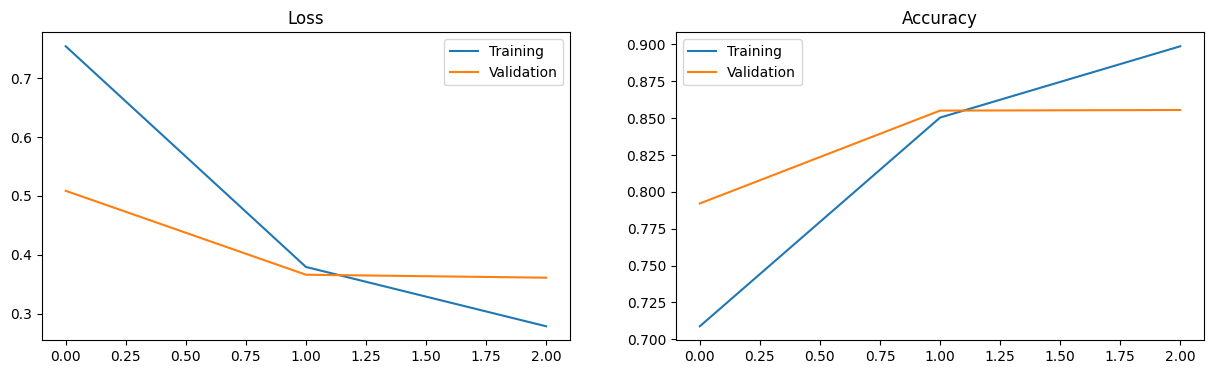

In [61]:
plt.figure(figsize = (15, 4))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(trainer.training_history['train_loss'], label = 'Training')
plt.plot(trainer.training_history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(trainer.training_history['train_acc'], label = 'Training')
plt.plot(trainer.training_history['val_acc'], label = 'Validation')
plt.legend()

## Predictions and Analysis

In [62]:
# Make predictions
predictions = []
true_labels = []

with torch.no_grad():
  for inputs, labels in tqdm(val_loader, desc="Making Predictions"):
    inputs = inputs.to(device)
    outputs = trainer.model(inputs)
    predicted_classes = torch.argmax(outputs, axis=1).cpu().numpy()
    predictions.extend(predicted_classes)
    true_labels.extend(labels.numpy())

Making Predictions: 100%|██████████| 7/7 [00:20<00:00,  3.00s/it]


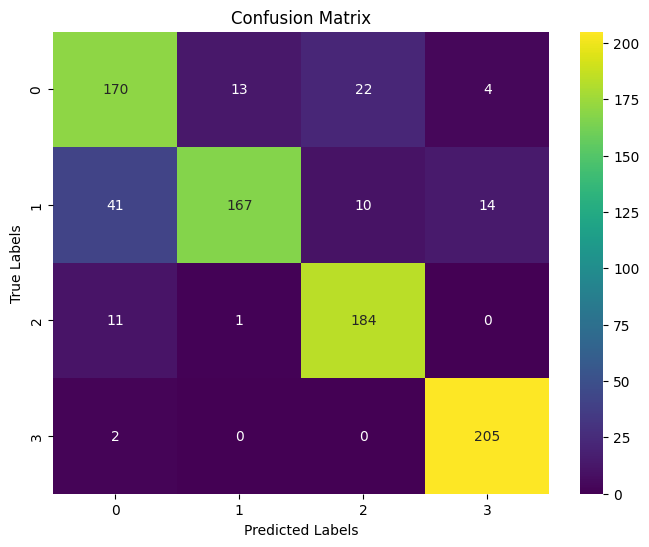

In [63]:
# Generate Confusion Matrix
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [64]:
# Generate Classification Report
report = classification_report(
  true_labels, predictions, target_names=list(label_to_id.keys())
)
print(report)

                      precision    recall  f1-score   support

            glaucoma       0.76      0.81      0.79       209
              normal       0.92      0.72      0.81       232
            cataract       0.85      0.94      0.89       196
diabetic_retinopathy       0.92      0.99      0.95       207

            accuracy                           0.86       844
           macro avg       0.86      0.87      0.86       844
        weighted avg       0.86      0.86      0.86       844

